In [1]:
import numpy as np
import pandas as pd
# from tqdm import tqdm
# from scipy.sparse import coo_matrix
from pyspark.ml.recommendation import ALS

# import sklearn
# import random 

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, IndexToString
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator



In [2]:
from pyspark.sql import SparkSession


MAX_MEMORY = "5g"
spark = SparkSession.builder.appName("recommender")\
.config("spark.executor.memory", MAX_MEMORY)\
.config("spark.driver.memory", MAX_MEMORY)\
.getOrCreate()

# spark = SparkSession\
#         .builder\
#         .appName('recommender_system')\
#         .getOrCreate()

22/05/09 10:40:24 WARN Utils: Your hostname, RedStone-MacBookAir.local resolves to a loopback address: 127.0.0.1; using 172.30.1.58 instead (on interface en0)
22/05/09 10:40:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/09 10:40:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# 데이터 불러오기
customers = pd.read_csv("data/customers.csv")
tran = pd.read_csv("data/transactions_train.csv")
item = pd.read_csv("data/articles.csv")

In [11]:
tran['t_dat'].min()

'2018-09-20'

In [12]:
tran['t_dat'].max()

'2020-09-22'

'2020-09-22'

In [4]:
ALL_USERS = customers['customer_id'].unique().tolist()
ALL_ITEMS = item['article_id'].unique().tolist()

user_ids = dict(list(enumerate(ALL_USERS)))
item_ids = dict(list(enumerate(ALL_ITEMS)))

user_map = {u: uidx for uidx, u in user_ids.items()}
item_map = {i: iidx for iidx, i in item_ids.items()}

tran['user_id'] = tran['customer_id'].map(user_map)
tran['item_id'] = tran['article_id'].map(item_map)

# del customers, customers


In [14]:
tran.head()

,t_dat,customer_id,article_id,price,sales_channel_id,user_id,item_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,2,40179
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,2,10520
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,7,6387
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,7,46304
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,7,46305


In [5]:
tran_18 = tran[tran['t_dat'] <= "2019-09-21"]
tran_19 = tran[tran['t_dat'] >= "2019-09-22"]

In [20]:
tran_19["t_dat"].min()

'2019-09-22'

In [6]:
tran_18 = tran.drop(['price', 'sales_channel_id'], axis=1)
tran_18.head(20)

,t_dat,customer_id,article_id,user_id,item_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,2,40179
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,2,10520
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,7,6387
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,7,46304
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,7,46305
5,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687001,7,46302
6,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221001,7,6386
7,2018-09-20,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,688873012,198,47416
8,2018-09-20,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,501323011,198,5944
9,2018-09-20,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,598859003,198,22540


In [7]:
rfm = pd.read_csv("data/result.csv")

In [8]:
rfm['t_dat']
rfm.head()

,customer_id,article_id,price,t_dat,age,count,total,t_dat_R,count_F,total_M,Class
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,176209023.0,0.035576,8467200.0,49.0,1,0.035576,2,1,8,2
1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,568601006.0,0.050831,21340800.0,49.0,2,0.101661,4,9,10,1
2,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,568601043.0,0.050831,61862400.0,49.0,1,0.050831,10,1,9,1
3,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,607642008.0,0.012695,26611200.0,49.0,1,0.012695,5,1,2,5
4,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,625548001.0,0.044051,8467200.0,49.0,1,0.044051,2,1,9,1


In [24]:
rfm = rfm[['customer_id', 'article_id', 't_dat_R', 'count_F', 'total_M']]
sum_factor = (rfm['t_dat_R']*0.503095271342921) + (rfm['count_F']*0) + (rfm['total_M']*0.49690472865707896)
rfm['rfm'] = sum_factor

In [25]:
rfm = rfm.drop(['t_dat_R', 'count_F', 'total_M'], axis=1)

In [31]:
rfm['t_dat']

0           2018-09-20
1           2018-09-20
2           2018-09-20
3           2018-09-20
4           2018-09-20
               ...    
31788319    2020-09-22
31788320    2020-09-22
31788321    2020-09-22
31788322    2020-09-22
31788323    2020-09-22
Name: t_dat, Length: 31788324, dtype: object

In [25]:
tran.head()

,customer_id,article_id,count,user_id,item_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,1,2,40179
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,1,2,10520
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,1,7,6387
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,1,7,46304
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,1,7,46305


In [33]:
rfm = rfm.merge(tran_18, on=['customer_id', 'article_id'], how='left')

In [34]:
# rfm['customer_id'] = rfm['customer_id'].astype(int)
# rfm['article_id'] = rfm['article_id'].astype(int)
rfm.head()

,customer_id,article_id,rfm,t_dat_x,user_id_x,item_id_x,t_dat_y,user_id_y,item_id_y
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001.0,5.472143,2018-09-20,2,40179,2018-09-20,2,40179
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001.0,5.472143,2018-09-20,2,40179,2018-09-24,2,40179
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023.0,3.484524,2018-09-20,2,10520,2018-09-20,2,10520
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004.0,1.993809,2018-09-20,7,6387,2018-09-20,7,6387
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003.0,1.993809,2018-09-20,7,46304,2018-09-20,7,46304


22/05/04 16:23:13 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1051007 ms exceeds timeout 120000 ms
22/05/04 16:23:13 WARN SparkContext: Killing executors is not supported by current scheduler.


In [29]:
rfm.to_csv('data/1year.csv', index=False)

In [17]:
rfm.head()

,customer_id,article_id,rfm,count,user_id,item_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001.0,5.472143,1,2,40179
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023.0,3.484524,1,2,10520
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004.0,1.993809,1,7,6387
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003.0,1.993809,1,7,46304
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004.0,1.993809,1,7,46305


In [ ]:
# # coo 변환
# row = df['user_id'].values
# col = df['item_id'].values
# data = np.ones(tran.shape[0])
# coo_train = coo_matrix((data, (row, col)), shape=(len(ALL_USERS), len(ALL_ITEMS)))
# coo_train

In [10]:
df_spark = spark.read.csv("data/1year.csv", inferSchema=True, header=True)
# coo_train = spark.createDataFrame(coo_train)

In [11]:
train, test = df_spark.randomSplit([0.75, 0.25])

rec = ALS(maxIter=10,
        regParam=0.01,
        userCol='user_id',
        itemCol='article_id',
        ratingCol='rfm', # label -> predict할 때는 필요 없음!
        nonnegative=True,
        implicitPrefs = True,
        coldStartStrategy='drop')
# ALS모델 학습 -> dataframe을 넣어주기
rec_model = rec.fit(train)

# transform을 이용해 예측 -> dataframe을 넣어주기
pred_ratings = rec_model.transform(test)
pred_ratings.limit(5).toPandas()

22/05/04 14:58:58 ERROR RetryingBlockTransferor: Exception while beginning fetch of 1 outstanding blocks 
java.io.IOException: Failed to connect to /172.26.133.123:62656
	at org.apache.spark.network.client.TransportClientFactory.createClient(TransportClientFactory.java:288)
	at org.apache.spark.network.client.TransportClientFactory.createClient(TransportClientFactory.java:218)
	at org.apache.spark.network.netty.NettyBlockTransferService$$anon$2.createAndStart(NettyBlockTransferService.scala:126)
	at org.apache.spark.network.shuffle.RetryingBlockTransferor.transferAllOutstanding(RetryingBlockTransferor.java:154)
	at org.apache.spark.network.shuffle.RetryingBlockTransferor.start(RetryingBlockTransferor.java:133)
	at org.apache.spark.network.netty.NettyBlockTransferService.fetchBlocks(NettyBlockTransferService.scala:146)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:102)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockM

Py4JJavaError: An error occurred while calling o264.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 851.0 failed 1 times, most recent failure: Lost task 0.0 in stage 851.0 (TID 1240) (172.26.133.123 executor driver): TaskResultLost (result lost from block manager)
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2454)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2402)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2402)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1160)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2642)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2279)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.sql.execution.SparkPlan.executeCollectIterator(SparkPlan.scala:401)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec.$anonfun$relationFuture$1(BroadcastExchangeExec.scala:137)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$1(SQLExecution.scala:185)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)


In [ ]:
u = rec.recommandProducts(26, 10)

In [6]:
pred_ratings.limit(100).toPandas()

,customer_id,article_id,rfm,count,user_id,item_id,prediction
0,0001177027259b455f979d85a278e4b280205d4de5cce4...,811715001.0,8.993809,1,26,83291,0.019086
1,0001177027259b455f979d85a278e4b280205d4de5cce4...,852149001.0,7.503095,1,26,91998,0.000770
2,0001177027259b455f979d85a278e4b280205d4de5cce4...,810170001.0,8.993809,1,26,82831,0.020321
3,0001177027259b455f979d85a278e4b280205d4de5cce4...,831429001.0,8.993809,1,26,88074,0.001218
4,0001177027259b455f979d85a278e4b280205d4de5cce4...,834063003.0,8.000000,1,26,88639,0.007951
...,...,...,...,...,...,...,...
95,0008d644deb96bdc0ca262f161cf6d5e9a4e619bb75faa...,654590001.0,7.987619,1,210,37697,0.103802
96,0008d644deb96bdc0ca262f161cf6d5e9a4e619bb75faa...,786304007.0,6.006191,1,210,76773,0.027577
97,0008d644deb96bdc0ca262f161cf6d5e9a4e619bb75faa...,456163062.0,7.503095,1,210,3511,0.022447
98,0008d644deb96bdc0ca262f161cf6d5e9a4e619bb75faa...,456163064.0,7.503095,1,210,3513,0.025737


22/05/04 14:43:47 WARN TransportChannelHandler: Exception in connection from /172.26.133.123:62656
java.io.IOException: Operation timed out
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:253)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:350)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:719)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:655)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.ja

In [17]:
dd = pred_ratings.toPandas()

In [25]:
dd['prediction'].count()

7894516

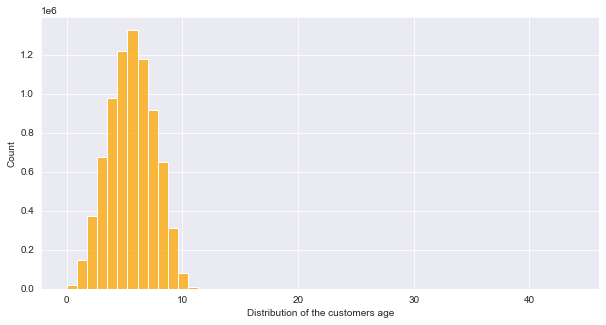

22/05/03 21:10:09 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 910275 ms exceeds timeout 120000 ms
22/05/03 21:10:09 WARN SparkContext: Killing executors is not supported by current scheduler.


In [28]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=dd, x='prediction', bins=50, color='orange')
ax.set_xlabel('Distribution of the customers age')
plt.show()

In [21]:
# Get metric for training
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol='rfm',
                              predictionCol='prediction',
                              metricName='rmse')
# evaluate 메소드에 예측값 담겨있는 dataframe 넣어주기
rmse = evaluator.evaluate(pred_ratings)

mae_eval = RegressionEvaluator(labelCol='rfm',
                              predictionCol='prediction',
                              metricName='mae')
mae = mae_eval.evaluate(pred_ratings)

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 1.0758949391149653
MAE: 0.7850179936343067


In [50]:
my_mc_lr = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='rfm', metricName='f1')
my_mc_lr.evaluate(pred_ratings)

IllegalArgumentException: requirement failed: Column prediction must be of type class org.apache.spark.sql.types.DoubleType$:double but was actually class org.apache.spark.sql.types.FloatType$:float.

In [22]:
# Pyspark Library #
# SQL
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import mean, col, split, regexp_extract, when, lit
# ML
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, IndexToString
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.recommendation import ALS


# stringIndexer = StringIndexer(inputCol='article_id',
#                             outputCol='article_new')
# print(stringIndexer)
# model = stringIndexer.bfit(df)
# indexed = model.transform(df)

# 숫자로 바꾼 영화제목들 중 Unique한 값들만 담아 추출하기 -> Dataframe 반환





In [56]:
pre1 = rfm
pre1.head(10)

,customer_id,article_id,rfm,count,user_id,item_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001.0,20,1,2,40179
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023.0,8,1,2,10520
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004.0,5,1,7,6387
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003.0,5,1,7,46304
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004.0,5,1,7,46305
5,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687001.0,5,1,7,46302
6,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221001.0,6,1,7,6386
7,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,688873012.0,8,1,198,47416
8,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,501323011.0,11,1,198,5944
9,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,598859003.0,11,1,198,22540


In [25]:
df = spark.read.csv('data/df4.csv', inferSchema=True, header=True)
unique_movies = df.select("article_id").distinct()

def top_movies(user_id, n):
    """
    특정 user_id가 좋아할 만한 n개의 영화 추천해주는 함수
    """
    # unique_movies 데이터프레임을 'a'라는 데이터프레임으로 alias시키기
    a = unique_movies.alias('a')

    # 특정 user_id가 본 영화들만 담은 새로운 데이터프레임 생성
    watched_movies = df.filter(df['user_id'] == user_id)\
                            .select('article_id')

    # 특정 user_id가 본 영화들을 'b'라는 데이터프레임으로 alias시키기
    b = watched_movies.alias('b')

    # unique_movies를 기준으로 watched_movies를 조인시켜서 user_id가 보지 못한 영화들 파악 가능
    total_movies = a.join(b, a['article_id'] == b['article_id'],
                        how='left')

    # b 데이터프레임의 title_new값이 결측치를 갖고 있는 행의 a.title_new를 뽑아냄으로써 user_id가 아직 못본 영화들 추출
    # col('b.title_new') => b 데이터프레임의 title_new칼럼 의미(SQL처럼 가능!)
    remaining_movies = total_movies\
                    .where(col('b.article_id').isNull())\
                    .select('a.article_id').distinct()
    # remaining_movies 데이터프레임에 특정 user_id값을 동일하게 새로운 변수로 추가해주기
    remaining_movies = remaining_movies.withColumn('user_id',
                                                lit(int(user_id)))
    # 위에서 만든 ALS 모델을 사용하여 추천 평점 예측 후 n개 만큼 view -> 
    recommender = rec_model.transform(remaining_movies)\
                        .orderBy('prediction', ascending=False)\
                        .limit(n)

    # pre = recommender.toPandas()
    # pre1 = rfm.merge(pre, on=['user_id', 'article_id'], how='right')
    # pre1 = rfm.merge(pre)
    # return pre
    return recommender.show(n, truncate=False)

# userid가 1817번인 유저가 볼만한 영화 상위 5개 추천해주기
top_movies(26, 100)

# StringIndexer로 만든 것을 역으로 바꾸기 위해 IndexToString사용(영화제목을 숫자->한글제목)
    # movie_title = IndexToString(inputCol='article_new',
    #                         outputCol='article_id',
    #                         labels=model.labels) #여기서 model.labels는 StringIndexer에서 fit시켰을 때 생긴 레이블. 즉, 영화 제목들
    # # transform해서 영화제목을 숫자->한글로 변환! => dataframe으로 반환
    # final_recommendations = movie_title.transform(recommender)

+------------+-------+----------+
|article_id  |user_id|prediction|
+------------+-------+----------+
|8.42055001E8|26     |45.68711  |
|8.74928004E8|26     |43.714424 |
|8.65973002E8|26     |43.169563 |
|8.25437009E8|26     |42.730442 |
|8.57351001E8|26     |40.385006 |
|6.63406006E8|26     |37.172943 |
|8.20727005E8|26     |36.268536 |
|9.10439002E8|26     |35.85482  |
|8.04809001E8|26     |35.30089  |
|8.87552004E8|26     |33.605003 |
|9.03210004E8|26     |33.110954 |
|8.23724002E8|26     |32.769886 |
|7.25172001E8|26     |32.26112  |
|7.42019005E8|26     |31.079556 |
|4.97637024E8|26     |30.794016 |
|5.56959003E8|26     |30.543354 |
|9.10458001E8|26     |30.118803 |
|8.32157002E8|26     |29.685555 |
|8.84105003E8|26     |28.753965 |
|4.8524001E8 |26     |28.689281 |
|9.05416001E8|26     |28.540844 |
|7.54027003E8|26     |28.3501   |
|9.18642002E8|26     |28.34587  |
|9.14363003E8|26     |28.109035 |
|9.15851002E8|26     |27.96997  |
|9.21715001E8|26     |27.95468  |
|8.58306005E8|

22/05/02 20:32:19 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 309652 ms exceeds timeout 120000 ms
22/05/02 20:32:19 WARN SparkContext: Killing executors is not supported by current scheduler.
